In [44]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [45]:
df_test = pd.read_csv(r"D:\yousef\Master\ML\project\models\multiclass\test_unscaled.csv")
df_train = pd.read_csv(r"D:\yousef\Master\ML\project\models\multiclass\train_unscaled.csv")


In [46]:
print(df_test["label_encoded"].value_counts(dropna=False))
print(df_test["label_encoded"].unique())
print(df_train["label_encoded"].value_counts(dropna=False))
print(df_train["label_encoded"].unique())


label_encoded
4     24274
9     19784
0     19566
8      9875
10     5702
3      2947
11     1786
1       734
2       669
7       543
5       248
6       137
12       10
Name: count, dtype: int64
[ 9  4  0 10 11  8  3  7  1  5  6  2 12]
label_encoded
4     97094
9     79133
0     78265
8     39498
10    22808
3     11788
11     7141
1      2935
2      2677
7      2174
5       994
6       548
12       41
Name: count, dtype: int64
[ 4  3  8  9  0 10  6 11  1  2  5  7 12]


In [47]:
X_train = df_train.drop(columns=['label','label_encoded','Bwd PSH Flags',
'Fwd URG Flags',
'Bwd URG Flags',
'FIN Flag Count',
'PSH Flag Count',
'ECE Flag Count',
'Fwd Avg Bytes/Bulk',
'Fwd Avg Packets/Bulk',
'Fwd Avg Bulk Rate',
'Bwd Avg Bytes/Bulk',
'Bwd Avg Packets/Bulk','Bwd Avg Bulk Rate'
])
y_train = df_train['label_encoded']
X_test = df_test.drop(columns=['label','label_encoded','Bwd PSH Flags',
'Fwd URG Flags',
'Bwd URG Flags',
'FIN Flag Count',
'PSH Flag Count',
'ECE Flag Count',
'Fwd Avg Bytes/Bulk',
'Fwd Avg Packets/Bulk',
'Fwd Avg Bulk Rate',
'Bwd Avg Bytes/Bulk',
'Bwd Avg Packets/Bulk','Bwd Avg Bulk Rate'
])
y_test = df_test['label_encoded']

In [38]:
# Step 1: train + temp (val + test)
X_train, x_val,y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, stratify=y_train, random_state=42
)

# # Step 2: split temp into validation and test
# X_val, X_test, y_val, y_test = train_test_split(
#     X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
# )

print("Train size:", X_train.shape[0])
print("Validation size:", x_val.shape[0])
print("Test size:", X_test.shape[0])


Train size: 241567
Validation size: 103529
Test size: 86275


In [48]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X, y, plot_cm=True, class_names=None, catboost=False):
    
    # Predict
    if catboost:
        y_pred = model.predict(X, prediction_type="Class")
    else:
        y_pred = model.predict(X)
    
    # Flatten CatBoost output if needed
    y_pred = np.array(y_pred).ravel()
    
    # Global metrics
    acc = accuracy_score(y, y_pred)
    f1_weighted = f1_score(y, y_pred, average='weighted')
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    
    # 🔥 F1 per class (13 classes)
    f1_per_class = f1_score(y, y_pred, average=None)
    
    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    
    # Print metrics
    print("Confusion Matrix:")
    print(cm)
    
    print(f"\nAccuracy        : {acc:.4f}")
    print(f"Weighted F1     : {f1_weighted:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall   : {recall:.4f}")
    
    print("\nF1-score per class:")
    for i, f1 in enumerate(f1_per_class):
        label = class_names[i] if class_names is not None else i
        print(f"Class {label}: {f1:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(
        y, y_pred,
        target_names=class_names,
        digits=4
    ))
    
    # Optional: Plot confusion matrix
    if plot_cm:
        plt.figure(figsize=(8,6))
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names
        )
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()
    
    metrics = {
        "accuracy": acc,
        "f1_weighted": f1_weighted,
        "precision_weighted": precision,
        "recall_weighted": recall,
        "f1_per_class": f1_per_class
    }
    
    return metrics, cm


In [49]:
from catboost import CatBoostClassifier

def Training(X_train, y_train, X_val, y_val):
    
    cat_model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=8,
        
        # 🔥 Multiclass settings
        loss_function='MultiClass',
        eval_metric='TotalF1',   # best F1 metric for multiclass
        auto_class_weights='Balanced',
        
        random_seed=42,
        verbose=100,
        early_stopping_rounds=50
    )

    cat_model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        use_best_model=True
    )
    
    return cat_model


In [42]:
cat_model=Training(X_train,y_train,x_val,y_val)
cat_model.save_model("D:\yousef\Master\ML\project\models\multiclass_models\catboost_model.cbm")


<>:2: SyntaxWarning: invalid escape sequence '\y'
<>:2: SyntaxWarning: invalid escape sequence '\y'
C:\Users\Yousef Amr\AppData\Local\Temp\ipykernel_21660\1242866633.py:2: SyntaxWarning: invalid escape sequence '\y'
  cat_model.save_model("D:\yousef\Master\ML\project\models\multiclass_models\catboost_model.cbm")


0:	learn: 0.5779744	test: 0.5670694	best: 0.5670694 (0)	total: 1.86s	remaining: 15m 27s
100:	learn: 0.8253885	test: 0.8029710	best: 0.8029710 (100)	total: 2m 58s	remaining: 11m 45s
200:	learn: 0.8545725	test: 0.8137335	best: 0.8172979 (154)	total: 5m 53s	remaining: 8m 45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8172979287
bestIteration = 154

Shrink model to first 155 iterations.


=== Validation Set Evaluation ===


Confusion Matrix:
[[23100    28     0     0     0     5    59     0    24     0     0    40
    224]
 [    0   392   184   125     9    48    20    98     0     0     4     1
      0]
 [    0    77   542    18     0     0     0   165     1     0     0     0
      0]
 [    1    72    63  3222     2    17    10   130     0    12     4     3
      0]
 [   16    43     1    44 28917     9    27     0     0     3     5     6
     57]
 [    0     5     2    37     0   188    61     2     0     0     2     0
      1]
 [    3     1     0     7     0    59    90     0     1     2     1     0
      0]
 [    0    12   110     6     0    22     1   499     0     0     0     0
      2]
 [   14     1     0    13     0     0    66     0 11637     0     2   114
      3]
 [    7     8     0    50     0     0    21     2     0 23599     0    45
      8]
 [    0    57     3   135    28    27    20     2     0     0  6313   258
      0]
 [    5    12     3    10     1     1     5     6     1     0   324  

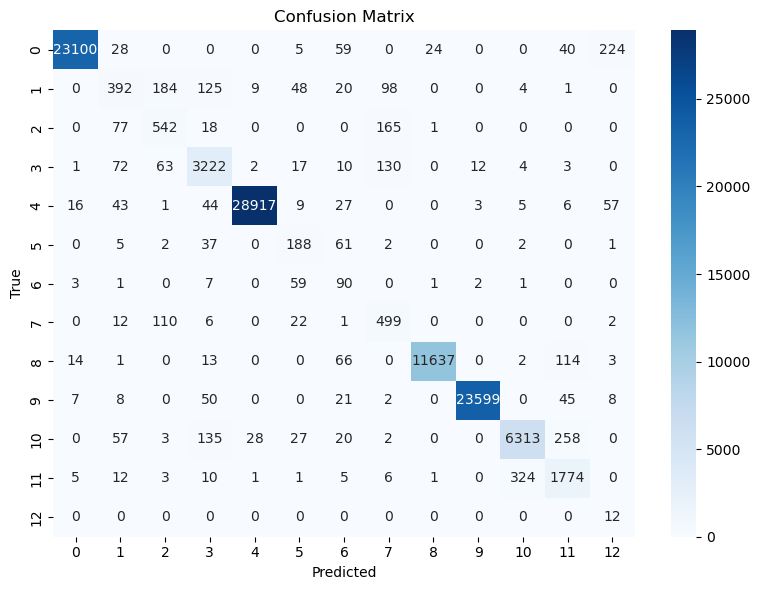

=== Test Set Evaluation ===
Confusion Matrix:
[[19273    15     2     1     0     3    41     0    22     0     0    30
    179]
 [    0   312   148   119     8    44    14    83     0     0     5     1
      0]
 [    1    58   476     7     0     0     0   127     0     0     0     0
      0]
 [    0    63    38  2704     3    16    14   102     0     4     2     1
      0]
 [   14    32     0    27 24110     9    11     0     0     3     9     7
     52]
 [    0     3     2    26     1   162    50     1     0     0     3     0
      0]
 [    3     0     0     5     0    52    77     0     0     0     0     0
      0]
 [    0     7    78     3     0    22     1   432     0     0     0     0
      0]
 [   18     1     0     6     0     0    45     0  9724     0     1    80
      0]
 [    9     8     0    49     0     0     9     3     0 19650     1    47
      8]
 [    0    31     0   137    21    16    17     1     0     0  5249   230
      0]
 [    2    13     5     8     0     1    

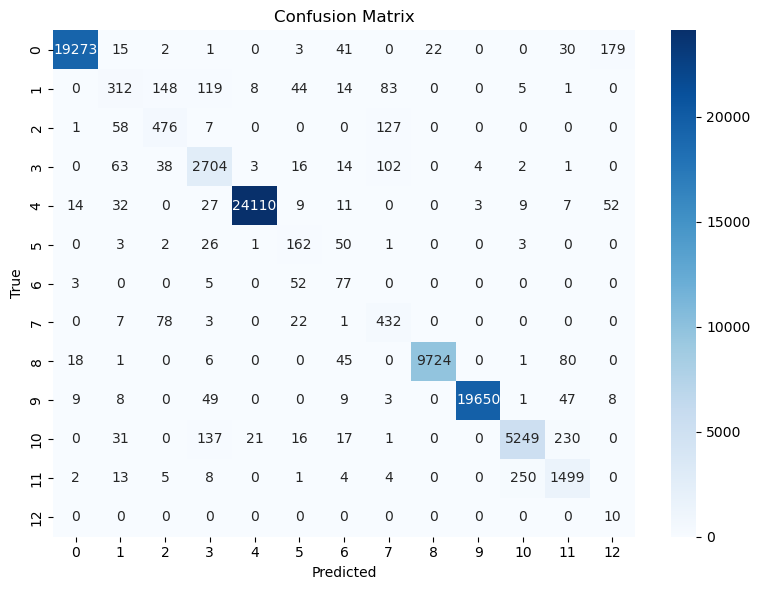

In [43]:
class_names = [str(i) for i in range(13)]  # or real class labels

print("=== Validation Set Evaluation ===")
metrics_val, cm_val = evaluate_model(
    cat_model,
    x_val, y_val,
    class_names=class_names,
    catboost=True
)

print("=== Test Set Evaluation ===")
metrics_test, cm_test = evaluate_model(
    cat_model,
    X_test, y_test,
    class_names=class_names,
    catboost=True
)


In [28]:
X_train_drop, X_val_drop, X_test_drop, y_train_drop, y_val_drop, y_test_drop =load_dataset(r"D:\yousef\Master\ML\project\models\data\Pre_drop_median")


In [29]:
cat_model=Training(X_train_drop,y_train_drop,X_val_drop,y_val_drop)
cat_model.save_model("D:\yousef\Master\ML\project\extra_tree\catboost_model_drop.cbm")

<>:2: SyntaxWarning: invalid escape sequence '\y'
<>:2: SyntaxWarning: invalid escape sequence '\y'
C:\Users\Yousef Amr\AppData\Local\Temp\ipykernel_31260\1365401213.py:2: SyntaxWarning: invalid escape sequence '\y'
  cat_model.save_model("D:\yousef\Master\ML\project\extra_tree\catboost_model_drop.cbm")


0:	learn: 0.9959036	test: 0.9960279	best: 0.9960279 (0)	total: 171ms	remaining: 1m 25s
100:	learn: 0.9997929	test: 0.9998000	best: 0.9998000 (98)	total: 15.5s	remaining: 1m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9998083605
bestIteration = 102

Shrink model to first 103 iterations.


=== Validation Set Evaluation ===
Confusion Matrix:
[[59980    20]
 [    3 59997]]

Accuracy: 0.9998
F1 Score: 0.9998
Precision: 0.9998
Recall: 0.9998

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60000
           1       1.00      1.00      1.00     60000

    accuracy                           1.00    120000
   macro avg       1.00      1.00      1.00    120000
weighted avg       1.00      1.00      1.00    120000



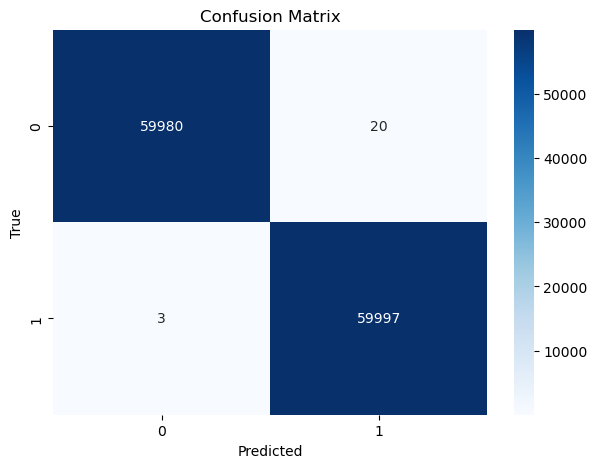

=== Test Set Evaluation ===
Confusion Matrix:
[[59974    26]
 [    2 59998]]

Accuracy: 0.9998
F1 Score: 0.9998
Precision: 0.9998
Recall: 0.9998

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60000
           1       1.00      1.00      1.00     60000

    accuracy                           1.00    120000
   macro avg       1.00      1.00      1.00    120000
weighted avg       1.00      1.00      1.00    120000



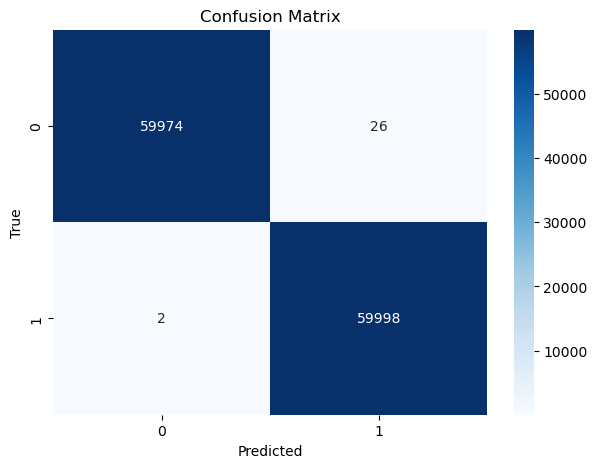

In [30]:
# Evaluate on validation set
print("=== Validation Set Evaluation ===")
metrics_val, cm_val = evaluate_model(
    cat_model,       # your trained CatBoost model
    X_val_drop, y_val_drop,
    class_names=[0,1],
    catboost=True    # because it's a CatBoost model
)

# Evaluate on test set
print("=== Test Set Evaluation ===")
metrics_test, cm_test = evaluate_model(
    cat_model,       # your trained CatBoost model
    X_test_drop, y_test_drop,
    class_names=[0,1],
    catboost=True
)


In [50]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier()
cat_model.load_model(r"D:\yousef\Master\ML\project\models\multiclass_models\catboost_model.cbm")


In [51]:
y_pred=cat_model.predict(X_test)
print(y_pred)

[[ 9]
 [ 4]
 [ 4]
 ...
 [ 9]
 [10]
 [ 9]]


In [52]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def kfold_catboost(X, y, num_classes=13,
                   k=5, epochs=100, learning_rate=0.1,
                   depth=8, batch_size=None, verbose=100):
    
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    fold_models = []
    fold_histories = []
    best_model = None
    best_f1 = -1
    best_fold = -1
    
    X_np = X.values if hasattr(X, "values") else X
    y_np = y.values if hasattr(y, "values") else y
    
    # Compute class weights
    classes = np.arange(num_classes)
    weights = compute_class_weight("balanced", classes=classes, y=y_np)
    class_weights = dict(zip(range(num_classes), weights))
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_np, y_np), 1):
        print(f"\n========== Fold {fold}/{k} ==========")
        X_train, X_val = X_np[train_idx], X_np[val_idx]
        y_train, y_val = y_np[train_idx], y_np[val_idx]
        
        model = CatBoostClassifier(
            iterations=epochs,
            learning_rate=learning_rate,
            depth=depth,
            loss_function='MultiClass',
            class_weights=weights.tolist(),
            verbose=verbose
        )
        
        train_pool = Pool(X_train, y_train)
        val_pool = Pool(X_val, y_val)
        
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=verbose)
        
        # Evaluate Macro F1
        y_pred = model.predict(X_val)
        val_f1 = f1_score(y_val, y_pred, average='macro')
        print(f"Fold {fold} | Validation Macro F1: {val_f1:.4f}")
        
        fold_models.append(model)
        fold_histories.append({
            "val_f1": val_f1,
            "best_iteration": model.get_best_iteration()
        })
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = model
            best_fold = fold
    
    print(f"\n🏆 Best model: Fold {best_fold} | Macro F1 = {best_f1:.4f}")
    return best_model, fold_models, fold_histories


In [53]:
best_cb_model, cb_models, cb_histories = kfold_catboost(
    X_train,
    y_train,
    num_classes=13,
    k=5,
    epochs=100,
    learning_rate=0.05,
    depth=8,
    verbose=100
)



========== Fold 1/5 ==========
0:	learn: 2.2485671	test: 2.2487634	best: 2.2487634 (0)	total: 2.58s	remaining: 4m 15s
99:	learn: 0.4879571	test: 0.5146062	best: 0.5146062 (99)	total: 3m 47s	remaining: 0us

bestTest = 0.5146062071
bestIteration = 99

Fold 1 | Validation Macro F1: 0.7083

========== Fold 2/5 ==========
0:	learn: 2.2537605	test: 2.2597834	best: 2.2597834 (0)	total: 2.37s	remaining: 3m 54s


KeyboardInterrupt: 

In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import copy

device = "cuda" if torch.cuda.is_available() else "cpu"

# Example BiLSTM model
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_classes=13, num_layers=1, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        return self.fc(x)

# Training function
def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=64, lr=1e-3, num_classes=13):
    # Convert to numpy if pandas
    if hasattr(X_train, "values"):
        X_train, X_val = X_train.values, X_val.values
    if hasattr(y_train, "values"):
        y_train, y_val = y_train.values, y_val.values

    # Class weights
    classes = np.arange(num_classes)
    weights = compute_class_weight("balanced", classes=classes, y=y_train)
    class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

    # Tensors
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
    y_val = torch.tensor(y_val, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_loss = float("inf")
    best_weights = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_loss += criterion(model(xb), yb).item()
        val_loss /= len(val_loader)

        if val_loss < best_loss:
            best_loss = val_loss
            best_weights = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_weights)
    return model

# Evaluate Macro F1
def evaluate_f1(model, X_val, y_val):
    if hasattr(X_val, "values"):
        X_val = X_val.values
    if hasattr(y_val, "values"):
        y_val = y_val.values
    X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(X_val)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
    return f1_score(y_val, preds, average="macro")

# K-Fold with Optuna
def kfold_optuna(model_class, X, y, num_classes=13, k=5, n_trials=20, epochs=50):
    X_np = X.values if hasattr(X, "values") else X
    y_np = y.values if hasattr(y, "values") else y

    best_overall_model = None
    best_overall_f1 = -1
    best_params = None
    fold_models = []
    fold_histories = []

    def objective(trial):
        hidden_size = trial.suggest_int("hidden_size", 32, 128)
        num_layers = trial.suggest_int("num_layers", 1, 3)
        dropout = trial.suggest_float("dropout", 0.1, 0.5)
        lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        f1_scores = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(X_np, y_np), 1):
            X_train, X_val = X_np[train_idx], X_np[val_idx]
            y_train, y_val = y_np[train_idx], y_np[val_idx]

            model = model_class(
                input_size=X_train.shape[1],
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout,
                num_classes=num_classes
            ).to(device)

            model = train_model(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, lr=lr)
            f1_scores.append(evaluate_f1(model, X_val, y_val))

        return np.mean(f1_scores)  # maximize average Macro F1

    # Run Optuna
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    print("Best hyperparameters:", study.best_params)

    # Train final model on full dataset with best hyperparameters
    best_params = study.best_params
    final_model = model_class(
        input_size=X_np.shape[1],
        hidden_size=best_params["hidden_size"],
        num_layers=best_params["num_layers"],
        dropout=best_params["dropout"],
        num_classes=num_classes
    ).to(device)

    final_model = train_model(final_model, X_np, y_np, X_np, y_np, epochs=epochs, batch_size=best_params["batch_size"], lr=best_params["lr"])
    best_overall_model = final_model

    return best_overall_model, study.best_params


In [ ]:
def catboost_kfold_training(
    X, y,
    k=5,
    param_grid=None,
    random_state=42
):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)

    if param_grid is None:
        param_grid = {
            "depth": [6, 8, 10],
            "learning_rate": [0.03, 0.1],
            "iterations": [300, 500],
            "l2_leaf_reg": [3, 5, 7]
        }

    best_macro_f1 = -1
    best_model = None
    best_params = None

    X_np = X.values if hasattr(X, "values") else X
    y_np = y.values if hasattr(y, "values") else y

    for params in ParameterGrid(param_grid):
        print(f"\n🔍 Testing params: {params}")
        fold_f1s = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(X_np, y_np), 1):
            X_train, X_val = X_np[train_idx], X_np[val_idx]
            y_train, y_val = y_np[train_idx], y_np[val_idx]

            model = CatBoostClassifier(
                **params,
                loss_function="MultiClass",
                eval_metric="TotalF1",
                auto_class_weights="Balanced",
                random_seed=random_state,
                verbose=False
            )

            model.fit(X_train, y_train)

            y_val_pred = model.predict(X_val).flatten()
            macro_f1 = f1_score(y_val, y_val_pred, average="macro")
            fold_f1s.append(macro_f1)

            print(f"  Fold {fold} | Macro F1: {macro_f1:.4f}")

        mean_f1 = np.mean(fold_f1s)
        print(f"➡️ Mean Macro F1: {mean_f1:.4f}")

        if mean_f1 > best_macro_f1:
            best_macro_f1 = mean_f1
            best_model = model
            best_params = params

    print("\n🏆 BEST MODEL FOUND")
    print("Best Params:", best_params)
    print("Best Macro F1:", best_macro_f1)

    return best_model, best_params


In [ ]:
best_cb_model, best_cb_params, best_cb_f1 = kfold_catboost_search(
    X=X_train,
    y=y_train,
    num_classes=13,
    k=5,
    n_iter=20
)
